# A Simple Introduction to 3D Gaussian Splatting

> see: https://medium.com/towards-data-science/a-python-engineers-introduction-to-3d-gaussian-splatting-part-1-e133b0449fc6  
> see: https://github.com/dcaustin33/intro_to_gaussian_splatting  

To begin, we use COLMAP, a software that extracts points consistently seen across multiple images using Structure from Motion (SfM). SfM essentially identifies points (e.g., the top right edge of a doorway) found in more than 1 picture. By matching these points across different images, we can estimate the depth of each point in 3D space. This closely emulates how human stereo vision works, where depth is perceived by comparing slightly different views from each eye. Thus, SfM generates a set of 3D points, each with x, y, and z coordinates, from the common points found in multiple images giving us the “structure” of the scene.

In this tutorial we will use a prebuilt COLMAP scan that is available for [download here](https://storage.googleapis.com/gresearch/refraw360/360_extra_scenes.zip) (Apache 2.0 license). Specifically we will be using the Treehill folder within the downloaded dataset.

In [1]:
import sys
sys.path.append('/home/ccj/code/my_github_projs/learn-3dv-up2date/src/splat_demo/')

!pip install pycolmap

from splat.gaussians import Gaussians
from splat.gaussian_scene import GaussianScene
import pycolmap
import torch
import torch.nn as nn
import numpy as np
import os
from os.path import join as pjoin

from splat.utils import read_images_text, read_images_binary

In [2]:
colmap_path = "/media/disk1_hdd_4T/datasets/3dgs-demo/360_extra_scenes/treehill/sparse/0"
result_path = "/home/ccj/code/my_github_projs/learn-3dv-up2date/results/3dgs_demo/"
model_path=pjoin(result_path, "point_clouds")
os.makedirs(result_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True) 

reconstruction = pycolmap.Reconstruction(colmap_path)

points3d = reconstruction.points3D
images = read_images_binary(f"{colmap_path}/images.bin")
cameras = reconstruction.cameras

all_points3d = []
all_point_colors = []

for idx, point in enumerate(points3d.values()):
    if point.track.length() >= 2:
        all_points3d.append(point.xyz)
        all_point_colors.append(point.color)

all_points3d = np.array(all_points3d)
all_point_colors = np.array(all_point_colors)

gaussians = Gaussians(
    torch.Tensor(all_points3d),
    torch.Tensor(all_point_colors),
    model_path=model_path,
)

Saved point clouds at /home/ccj/code/my_github_projs/learn-3dv-up2date/results/3dgs_demo/point_clouds/point_cloud.ply


## Get the intrinsic and extrinsic matrices

In [3]:
from splat.utils import read_camera_file, read_image_file, build_rotation


def get_extrinsic_matrix(R: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """
    Get the homogenous extrinsic matrix for the camera
    """
    Rt = torch.zeros((4, 4))
    Rt[:3, :3] = R
    Rt[:3, 3] = t
    Rt[3, 3] = 1.0
    return Rt


def get_intrinsic_matrix(
    f_x: float, f_y: float, c_x: float, c_y: float
) -> torch.Tensor:
    """
    Get the homogenous intrinsic matrix for the camera
    """
    return torch.Tensor(
        [
            [f_x, 0, c_x, 0],
            [0, f_y, c_y, 0],
            [0, 0, 1, 0],
        ]
    )


# We will examine the 100th image
image_num = 100
image_dict = read_image_file(colmap_path)
camera_dict = read_camera_file(colmap_path)

# convert quaternion to rotation matrix
rotation_matrix = build_rotation(torch.Tensor(image_dict[image_num].qvec).unsqueeze(0))
translation = torch.Tensor(image_dict[image_num].tvec).unsqueeze(0)
extrinsic_matrix = get_extrinsic_matrix(rotation_matrix, translation)
focal_x, focal_y = camera_dict[image_dict[image_num].camera_id].params[:2]
c_x, c_y = camera_dict[image_dict[image_num].camera_id].params[2:4]
intrinsic_matrix = get_intrinsic_matrix(focal_x, focal_y, c_x, c_y)

## Now we can project the points to the image plane

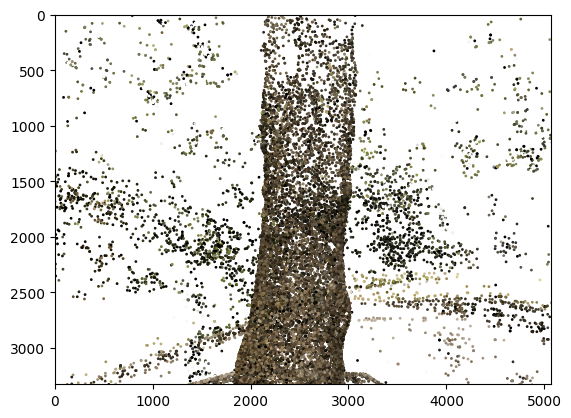

In [4]:
from matplotlib import pyplot as plt


def project_points(
    points: torch.Tensor, intrinsic_matrix: torch.Tensor, extrinsic_matrix: torch.Tensor
) -> torch.Tensor:
    """
    Project the points to the image plane

    Args:
        points: Nx3 tensor
        intrinsic_matrix: 3x4 tensor
        extrinsic_matrix: 4x4 tensor
    """
    homogeneous = torch.ones((4, points.shape[0]), device=points.device)
    homogeneous[:3, :] = points.T
    projected_to_camera_perspective = extrinsic_matrix @ homogeneous
    projected_to_image_plane = (
        intrinsic_matrix @ projected_to_camera_perspective
    ).T  # Nx4

    x = projected_to_image_plane[:, 0] / projected_to_image_plane[:, 2]
    y = projected_to_image_plane[:, 1] / projected_to_image_plane[:, 2]
    return x, y

device = gaussians.points.device
points = project_points(gaussians.points, intrinsic_matrix.to(device), extrinsic_matrix.to(device))
plt.scatter(
    points[0].cpu().detach(), points[1].cpu().detach(), c=gaussians.colors.cpu().detach(), s=1
)
plt.xlim(0, camera_dict[image_dict[image_num].camera_id].width)
plt.ylim(0, camera_dict[image_dict[image_num].camera_id].height)
plt.gca().invert_yaxis()

In [5]:
image_dict[100]

Image(id=100, qvec=array([ 0.96282662, -0.23562335,  0.12748722,  0.0345476 ]), tvec=array([0.0530637 , 0.87330016, 3.58750122]), camera_id=1, name='_DSC8973.JPG', xys=array([[ 4.49721720e+02, -1.94575598e+01],
       [ 1.37280789e+03, -5.65410890e-01],
       [ 1.37280789e+03, -5.65410890e-01],
       ...,
       [ 3.89330626e+03,  8.34139975e+02],
       [ 3.54521027e+03,  1.99674567e+03],
       [ 1.32671838e+03,  2.59199648e+02]]), point3D_ids=array([-1, -1, -1, ..., -1, -1, -1]))

## Convert 3d gaussians to 2d

Note: we are only using isotropic gaussians for now.

In [6]:
import math

from splat.utils import (
    read_camera_file,
    read_image_file,
    build_rotation,
    in_view_frustum,
)


def getIntinsicMatrix(
    focal_x: torch.Tensor,
    focal_y: torch.Tensor,
    height: torch.Tensor,
    width: torch.Tensor,
    zfar: torch.Tensor = torch.Tensor([100.0]),
    znear: torch.Tensor = torch.Tensor([0.001]),
) -> torch.Tensor:
    """
    Gets the internal perspective projection matrix

    znear: near plane set by user
    zfar: far plane set by user
    fovX: field of view in x, calculated from the focal length
    fovY: field of view in y, calculated from the focal length
    """
    fovX = torch.Tensor([2 * math.atan(width / (2 * focal_x))])
    fovY = torch.Tensor([2 * math.atan(height / (2 * focal_y))])

    tanHalfFovY = math.tan((fovY / 2))
    tanHalfFovX = math.tan((fovX / 2))

    top = tanHalfFovY * znear
    bottom = -top
    right = tanHalfFovX * znear
    left = -right

    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * znear / (right - left)
    P[1, 1] = 2.0 * znear / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[3, 2] = z_sign
    P[2, 2] = z_sign * zfar / (zfar - znear)
    P[2, 3] = -(zfar * znear) / (zfar - znear)
    return P


def compute_2d_covariance(
    points: torch.Tensor,
    extrinsic_matrix: torch.Tensor,
    covariance_3d: torch.Tensor,
    tan_fovY: torch.Tensor,
    tan_fovX: torch.Tensor,
    focal_x: torch.Tensor,
    focal_y: torch.Tensor,
) -> torch.Tensor:
    """
    Compute the 2D covariance matrix for each Gaussian
    """
    points = torch.cat(
        [points, torch.ones(points.shape[0], 1, device=points.device)], dim=1
    )
    points_transformed = (points @ extrinsic_matrix)[:, :3]
    limx = 1.3 * tan_fovX
    limy = 1.3 * tan_fovY
    x = points_transformed[:, 0] / points_transformed[:, 2]
    y = points_transformed[:, 1] / points_transformed[:, 2]
    z = points_transformed[:, 2]
    x = torch.clamp(x, -limx, limx) * z
    y = torch.clamp(y, -limy, limy) * z

    J = torch.zeros((points_transformed.shape[0], 3, 3), device=covariance_3d.device)
    J[:, 0, 0] = focal_x / z
    J[:, 0, 2] = -(focal_x * x) / (z**2)
    J[:, 1, 1] = focal_y / z
    J[:, 1, 2] = -(focal_y * y) / (z**2)

    # transpose as originally set up for perspective projection
    # so we now transform back
    W = extrinsic_matrix[:3, :3].T

    return (J @ W @ covariance_3d @ W.T @ J.transpose(1, 2))[:, :2, :2]


covariance_3d = gaussians.get_3d_covariance_matrix()

# we will examine the 100th image
image_num = 100
image_dict = read_image_file(colmap_path)
camera_dict = read_camera_file(colmap_path)

# convert quaternion to rotation matrix
rotation_matrix = build_rotation(torch.Tensor(image_dict[image_num].qvec).unsqueeze(0))
translation = torch.Tensor(image_dict[image_num].tvec).unsqueeze(0)
extrinsic_matrix = get_extrinsic_matrix(rotation_matrix, translation).to(device)

focal_x, focal_y = camera_dict[image_dict[image_num].camera_id].params[:2]
c_x, c_y = camera_dict[image_dict[image_num].camera_id].params[2:4]
width = camera_dict[image_dict[image_num].camera_id].width
height = camera_dict[image_dict[image_num].camera_id].height

# note we transpose the intrinsic matrix
intrinsic_matrix = getIntinsicMatrix(focal_x, focal_y, height, width).T.to(device)

in_view = in_view_frustum(
    points=gaussians.points,
    view_matrix=extrinsic_matrix.T,
)

fovX = torch.Tensor([2 * math.atan(width / (2 * focal_x))])
fovY = torch.Tensor([2 * math.atan(height / (2 * focal_y))])


covariance_2d = compute_2d_covariance(
    points=gaussians.points[in_view],
    extrinsic_matrix=extrinsic_matrix.T,
    covariance_3d=covariance_3d[in_view],
    tan_fovY = torch.tan(fovX / 2).to(device),
    tan_fovX=torch.tan(fovX / 2).to(device),
    focal_x=focal_x,
    focal_y=focal_y,
)

In [7]:
def compute_inverted_covariance(covariance_2d: torch.Tensor) -> torch.Tensor:
    """
    Compute the inverse covariance matrix

    For a 2x2 matrix
    given as
    [[a, b],
     [c, d]]
     the determinant is ad - bc

    To get the inverse matrix reshuffle the terms like so
    and multiply by 1/determinant
    [[d, -b],
     [-c, a]] * (1 / determinant)
    """
    determinant = (
        covariance_2d[:, 0, 0] * covariance_2d[:, 1, 1]
        - covariance_2d[:, 0, 1] * covariance_2d[:, 1, 0]
    )
    determinant = torch.clamp(determinant, min=1e-3)
    inverse_covariance = torch.zeros_like(covariance_2d)
    inverse_covariance[:, 0, 0] = covariance_2d[:, 1, 1] / determinant
    inverse_covariance[:, 1, 1] = covariance_2d[:, 0, 0] / determinant
    inverse_covariance[:, 0, 1] = -covariance_2d[:, 0, 1] / determinant
    inverse_covariance[:, 1, 0] = -covariance_2d[:, 1, 0] / determinant
    return inverse_covariance


def compute_extent_and_radius(covariance_2d: torch.Tensor):
    mid = 0.5 * (covariance_2d[:, 0, 0] + covariance_2d[:, 1, 1])
    det = covariance_2d[:, 0, 0] * covariance_2d[:, 1, 1] - covariance_2d[:, 0, 1] ** 2
    intermediate_matrix = (mid * mid - det).view(-1, 1)
    intermediate_matrix = torch.cat(
        [intermediate_matrix, torch.ones_like(intermediate_matrix) * 0.1], dim=1
    )

    max_values = torch.max(intermediate_matrix, dim=1).values
    lambda1 = mid + torch.sqrt(max_values)
    lambda2 = mid - torch.sqrt(max_values)
    # now we have the eigenvalues, we can calculate the max radius
    max_radius = torch.ceil(3.0 * torch.sqrt(torch.max(lambda1, lambda2)))

    return max_radius


inverted_covariance = compute_inverted_covariance(covariance_2d)
extent = compute_extent_and_radius(covariance_2d)

## We can now calculate the strength of any splat!

In [8]:
from splat.utils import ndc2Pix

splat = gaussians.points[in_view][:1]
splat_2d_covariance = covariance_2d[:1]

# project the splat to 2D
homogeneous_splat = torch.cat(
    [splat, torch.ones(splat.shape[0], 1, device=splat.device)], dim=1
)
print (homogeneous_splat.device, extrinsic_matrix.device, intrinsic_matrix.device)

temp_splat = homogeneous_splat @ extrinsic_matrix.T @ intrinsic_matrix
splat_image_plane = temp_splat[:, :3] / temp_splat[:, 3].unsqueeze(1)
splat_xy = splat_image_plane[:, :2]

# convert to pixel coordinates from normalized device coordinates
splat_xy[:, 0] = ndc2Pix(splat_xy[:, 0], width)
splat_xy[:, 1] = ndc2Pix(splat_xy[:, 1], height)
inverted_splat_2d_covariance = compute_inverted_covariance(splat_2d_covariance)
radius = compute_extent_and_radius(splat_2d_covariance)


def compute_gaussian_weight(
    pixel_coord: torch.Tensor,  # (1, 2) tensor
    point_mean: torch.Tensor,
    inverse_covariance: torch.Tensor,
) -> torch.Tensor:

    difference = point_mean - pixel_coord
    power = -0.5 * difference @ inverse_covariance @ difference.T
    return torch.exp(power).item()


strength = compute_gaussian_weight(
    pixel_coord=splat_xy - 0.01,
    point_mean=splat_xy,
    inverse_covariance=inverted_splat_2d_covariance,
)
print(f"The strength with a .1 pixel offset in the x direction is {strength}")
strength = compute_gaussian_weight(
    pixel_coord=splat_xy - 1,
    point_mean=splat_xy,
    inverse_covariance=inverted_splat_2d_covariance,
)
print(f"The strength with a 1 pixel offset in the x direction is {strength}")
strength = compute_gaussian_weight(
    pixel_coord=splat_xy - 10,
    point_mean=splat_xy,
    inverse_covariance=inverted_splat_2d_covariance,
)
print(f"The strength with a 10 pixel offset in the x direction is {strength}")

cuda:0 cuda:0 cuda:0
The strength with a .1 pixel offset in the x direction is 0.9999192953109741
The strength with a 1 pixel offset in the x direction is 0.44674497842788696
The strength with a 10 pixel offset in the x direction is 1.0138366139213011e-35


## Now we just need to render!

In [9]:
all_points3d = []
all_point_colors = []
image_num = 100

for idx, point in enumerate(points3d.values()):
    # I would assume this is seeing it from multiple images
    if point.track.length() >= 2:
        all_points3d.append(point.xyz)
        all_point_colors.append(point.color)

image = images[image_num]
points_in_3d = []
points2d = []
colors2d = []
for idx, point in enumerate(image.xys):
    point3d_id = image.point3D_ids[idx]
    if point3d_id > 0:
        try:
            color = points3d[point3d_id].color
            points_in_3d.append(points3d[point3d_id].xyz)
            points2d.append(point)
            colors2d.append(color)
        except:
            pass

all_points3d = np.array(all_points3d)
all_point_colors = np.array(all_point_colors)
points_in_3d = np.array(points_in_3d)
points2d = np.array(points2d)
colors2d = np.array(colors2d)

print(all_points3d.shape, points_in_3d.shape)
gaussians = Gaussians(
    torch.Tensor(all_points3d),
    torch.Tensor(all_point_colors),
    model_path=model_path,
)

(52363, 3) (1697, 3)
Saved point clouds at /home/ccj/code/my_github_projs/learn-3dv-up2date/results/3dgs_demo/point_clouds/point_cloud.ply


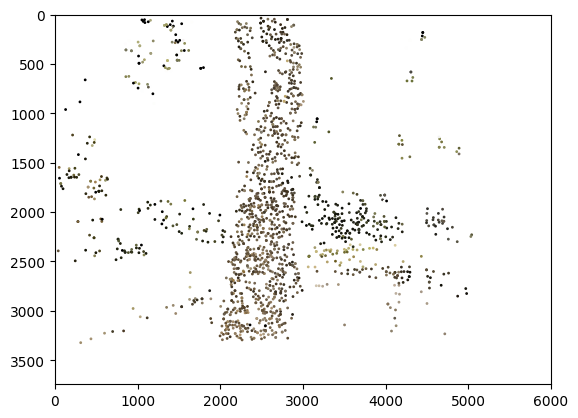

In [10]:
scene = GaussianScene(
    colmap_path=colmap_path,
    gaussians=gaussians,
)

plt.scatter(points2d[:, 0], points2d[:, 1], c=colors2d / 256, s=1)
plt.xlim(0, 6000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis()

In [11]:
from pathlib import Path
from torch.utils.cpp_extension import load_inline

src_path = Path("/home/ccj/code/my_github_projs/learn-3dv-up2date/src/splat_demo/")
cuda_src = (src_path/"splat/c/render.cu").read_text()
cpp_src = """
torch::Tensor render_image(
    int image_height,
    int image_width,
    int tile_size,
    torch::Tensor point_means,
    torch::Tensor point_colors,
    torch::Tensor inverse_covariance_2d,
    torch::Tensor min_x,
    torch::Tensor max_x,
    torch::Tensor min_y,
    torch::Tensor max_y,
    torch::Tensor opacity);
"""


os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


def load_cuda(cuda_src, cpp_src, funcs, opt=True, verbose=False):
    return load_inline(
        name="inline_ext",
        cpp_sources=[cpp_src],
        cuda_sources=[cuda_src],
        functions=funcs,
        extra_cuda_cflags=["-O1"] if opt else [],
        verbose=verbose,
    )


# Set MAX_JOBS for parallel compilation
os.environ["MAX_JOBS"] = "10"

# Compile and load the CUDA module
module = load_cuda(cuda_src, cpp_src, ["render_image"], opt=True, verbose=True)

Using /home/ccj/.cache/torch_extensions/py310_cu126 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/ccj/.cache/torch_extensions/py310_cu126/inline_ext/build.ninja...
/home/ccj/miniconda3/envs/3dvGS/lib/python3.10/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext...
Using envvar MAX_JOBS (10) as the number of workers...


ninja: no work to do.


Loading extension module inline_ext...


In [12]:
image = scene.render_image_cuda(image_num, tile_size=16, src_path = src_path)

Using /home/ccj/.cache/torch_extensions/py310_cu126 as PyTorch extensions root...
The input conditions for extension module inline_ext have changed. Bumping to version 1 and re-building as inline_ext_v1...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/ccj/.cache/torch_extensions/py310_cu126/inline_ext/build.ninja...
/home/ccj/miniconda3/envs/3dvGS/lib/python3.10/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext_v1...
Using envvar MAX_JOBS (10) as the number of workers...


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /home/ccj/miniconda3/envs/3dvGS/lib/python3.10/site-packages/torch/include -isystem /home/ccj/miniconda3/envs/3dvGS/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /home/ccj/miniconda3/envs/3dvGS/lib/python3.10/site-packages/torch/include/TH -isystem /home/ccj/miniconda3/envs/3dvGS/lib/python3.10/site-packages/torch/include/THC -isystem /usr/local/cuda-12.6/include -isystem /home/ccj/miniconda3/envs/3dvGS/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -c /home/ccj/.cache/torch_extensions/py310_cu126/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda-12.6/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -

Loading extension module inline_ext_v1...


Operation took seconds:  1.4087803363800049


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..252.46783].


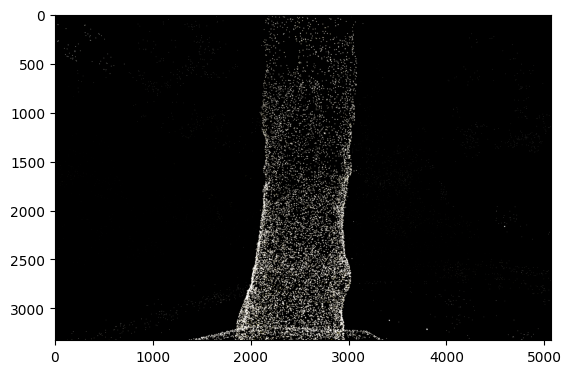

In [13]:
from matplotlib import pyplot as plt

plt.imshow(image.detach().cpu() * 256)